# Audio Classification

## Preprocessing

* All input audio files are processed to equal lengths using zero padding or cutting
* Audio downsampled to 22050 from 41000 to reduce complexity
* Mel Frequency Cepstral Coefficients (MFCC) used for collecting features
* MFCC converted the audio classification task to an image classification task

## Training procedure
* Transfer learning using pretrained DenseNet for classifying the data. Resnet18, various CNN and RNN models were also tried out, but the results were unsatisfactory.
* Optimizer used is Adam with learning rate = 1e-3.
* Criterion used is Cross Entropy Loss
* Scheduler used StepLR whose parameters are from the PyTorch docs
* Training epochs: 20

## Final results:
* Training & validation accuracy: 98% (similar due to small train test split)
* Plots have been made towards the end of the report


In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as aT
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Load dataset

In [3]:
# ? hyperparams

n_mels = 320
original_rate = 44100
sample_rate = 22050

lr = 0.0001
num_epochs = 20

batch_size = 2


In [4]:
def audio_loader(path, max_length_in_seconds=4):
    waveform, sample_rate = torchaudio.load(path)
    num_channels, num_frames = waveform.shape
    max_frames = sample_rate * max_length_in_seconds

    # ? Pad audio with zeros if too short or cut audio if too long
    if num_frames < max_frames:
        waveform = torch.nn.functional.pad(waveform, (0, max_frames - num_frames))
    elif num_frames > max_frames:
        waveform = waveform.narrow(dim=1, start=0, length=max_frames)

    return waveform

transforms = nn.Sequential(
    aT.Resample(original_rate, sample_rate),
    aT.MFCC(sample_rate=sample_rate, n_mfcc=64),
    aT.AmplitudeToDB(),
)

dataset = DatasetFolder(root='./dataset', loader=audio_loader, extensions='wav', transform=transforms)
print(f"Input shape: {tuple(dataset[0][0].shape)}")

classes = dataset.classes
print("Classes:", classes)


Input shape: (1, 64, 442)
Classes: ['1', '2', '3', '4', '5', '6', '7']


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:
train_dataset, valid_dataset = random_split(
    dataset,
    lengths=[int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))]
)

# ? dataloader
train_dataloader = DataLoader(
    train_dataset.dataset,
    batch_size=batch_size,
    shuffle=True,
)

valid_dataloader = DataLoader(
    valid_dataset.dataset,
    batch_size=batch_size,
    shuffle=True,
)


# Model, optimizers and criterion

In [6]:
class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.model = models.densenet201(pretrained=True)
        conv0 = self.model.features.conv0
        self.model.features.conv0 = nn.Conv2d(
            1,
            conv0.out_channels,
            kernel_size=conv0.kernel_size,
            stride=conv0.stride,
            padding=conv0.padding,
        )
        self.model.classifier = nn.Linear(1920, num_classes)

    def forward(self, x):
        output = self.model(x)
        return output


model = DenseNet(len(classes))
model.to(device)


DenseNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True

In [7]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)


# Training and validation

In [8]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # ? zero the parameter gradients
        optimizer.zero_grad()

        # ? forward pass, backward pass & optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)


def valid(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0
    num_correct = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            num_correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    accuracy = 100 * num_correct / len(valid_loader.dataset)

    return valid_loss, accuracy


In [9]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

writer = SummaryWriter(comment="audio_classification_densenet")

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    _, train_accuracy = valid(model, train_dataloader, criterion)

    valid_loss, valid_accuracy = valid(model, valid_dataloader, criterion)

    scheduler.step()

    writer.add_scalar('training loss/train_loss', train_loss, epoch)
    writer.add_scalar('validation loss/valid_loss', valid_loss, epoch)

    writer.add_scalar('training accuracy/train_acc', train_accuracy, epoch)
    writer.add_scalar('validation accuracy/valid_acc', valid_accuracy, epoch)

    writer.add_scalar('learning rate/lr', optimizer.param_groups[0]['lr'], epoch)

    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_accuracy)

    print(
        f'Epoch: {epoch+1}/{num_epochs}\t'
        f'Training (Loss, Accuracy): ({train_loss:.6f}, {train_accuracy:.2f}%)\t'
        f'Validation (Loss, Accuracy): ({valid_loss:.6f}, {valid_accuracy:.2f}%)\t'
    )

writer.close()

PATH = './IE643_190020066_CHALLENGE_MODEL.pt'
torch.save(model, PATH)


C:\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/20	Training (Loss, Accuracy): (1.972921, 57.14%)	Validation (Loss, Accuracy): (1.391234, 57.14%)	
Epoch: 2/20	Training (Loss, Accuracy): (1.691869, 70.59%)	Validation (Loss, Accuracy): (1.058345, 70.59%)	
Epoch: 3/20	Training (Loss, Accuracy): (1.451026, 78.99%)	Validation (Loss, Accuracy): (0.788085, 78.99%)	
Epoch: 4/20	Training (Loss, Accuracy): (1.342277, 78.15%)	Validation (Loss, Accuracy): (0.617975, 78.15%)	
Epoch: 5/20	Training (Loss, Accuracy): (1.280453, 94.96%)	Validation (Loss, Accuracy): (0.398357, 94.96%)	
Epoch: 6/20	Training (Loss, Accuracy): (0.991641, 91.60%)	Validation (Loss, Accuracy): (0.389029, 91.60%)	
Epoch: 7/20	Training (Loss, Accuracy): (0.835899, 94.96%)	Validation (Loss, Accuracy): (0.276830, 94.96%)	
Epoch: 8/20	Training (Loss, Accuracy): (0.769999, 96.64%)	Validation (Loss, Accuracy): (0.232832, 96.64%)	
Epoch: 9/20	Training (Loss, Accuracy): (0.739021, 96.64%)	Validation (Loss, Accuracy): (0.223099, 96.64%)	
Epoch: 10/20	Training (Loss, Accuracy

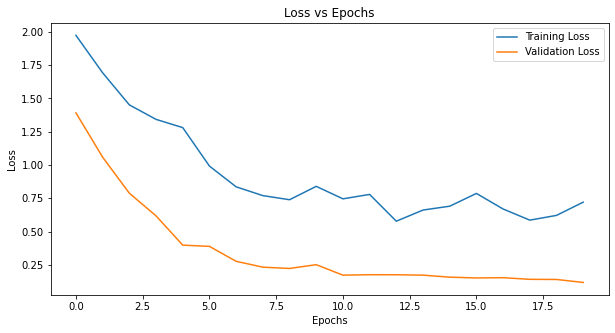

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


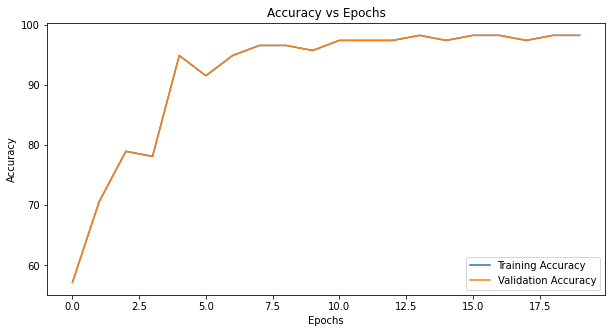

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()
